
# Native Language Identification (IndicAccentDb) — Colab Notebook
**This notebook is prepared for:** `facebook/hubert-base-ls960` (recommended), GPU runtime in Colab, and includes MFCC + HuBERT pipelines, training, evaluation, layer-wise analysis, and a small Accent→Cuisine demo.

**Before running:** Runtime → Change runtime type → **GPU**

If you see any install errors, copy the error text here and I'll fix it quickly.


In [ ]:


# ✅ Install proven compatible combination
!pip install -q tokenizers==0.19.1
!pip install -q transformers==4.39.3

# ✅ Rest of required packages
!pip install -q datasets==2.18.0 scikit-learn torchaudio librosa pandas matplotlib wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.2 requires tokenizers<=0.23.0,>=0.22.0, but you have tokenizers 0.19.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.39.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:

# === Imports ===
import os, random, math, json
from pathlib import Path
from typing import List, Dict, Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchaudio
import librosa

from transformers import AutoFeatureExtractor, HubertModel
from datasets import load_dataset

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('torch:', torch.__version__)
print('transformers:', __import__('transformers').__version__)


torch: 2.9.0+cu126
transformers: 4.39.3


In [ ]:

# === Configuration & helpers ===
class CFG:
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sample_rate = 16000
    max_duration = 6.0
    n_mfcc = 40
    batch_size = 32
    lr = 1e-4
    epochs = 12
    hubert_model_name = "facebook/hubert-base-ls960"
    num_workers = 2
    save_dir = "models"
os.makedirs(CFG.save_dir, exist_ok=True)

def seed_everything(seed=CFG.seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

def compute_mfcc(wav, sr=CFG.sample_rate, n_mfcc=CFG.n_mfcc):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)
    return mfcc.astype('float32')


In [ ]:
# === Load the IndicAccentDb dataset (HuggingFace) ===
from datasets import load_dataset # Explicitly import load_dataset

print('Loading dataset... this may take a few minutes')
ds = load_dataset('DarshanaS/IndicAccentDb')

print(ds)
# Inspect one example
example = next(iter(ds['train']))
print('\nExample keys:', list(example.keys()))
print('Audio field sample:', example.get('audio') is not None)

Loading dataset... this may take a few minutes


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 8116
    })
})

Example keys: ['audio', 'label']
Audio field sample: True


In [ ]:
from datasets import load_dataset, Audio
import pandas as pd

# ✅ Load entire dataset, but keep it memory-mapped (not all in RAM)
full_ds = load_dataset(
    "DarshanaS/IndicAccentDb",
    split="train",
    streaming=False,
    cache_dir="/content/hf_cache"  # optional: saves to disk
)

# ✅ Add resampling to the dataset at an early stage
# This ensures that when 'audio' is accessed, it's already at CFG.sample_rate
full_ds = full_ds.cast_column("audio", Audio(sampling_rate=CFG.sample_rate))

# ✅ Extract label names
actual_label_names = full_ds.features["label"].names
lang2id = {name: i for i, name in enumerate(actual_label_names)}
id2lang = {i: name for i, name in enumerate(actual_label_names)}

print("✅ Language to ID mapping (string to int):", lang2id)
print("✅ ID to Language mapping (int to string):", id2lang)
print("✅ Actual accent labels:", actual_label_names)

# ✅ Instead of storing full audio arrays in a DataFrame,
# only store the *file paths* to the audio data.
metadata = []

for i in range(len(full_ds)):
    ex = full_ds[i]
    metadata.append({
        "audio_path": ex["audio"]["path"],   # file reference, not waveform
        "language": ex["label"],
        "text": ex.get("text", ""),
        "age": ex.get("age", None),
        "split": "train"
    })

df = pd.DataFrame(metadata)
df["lang_id"] = df["language"]

print("✅ Total rows (full dataset):", len(df))
display(df.head())

Generating train split: 0 examples [00:00, ? examples/s]

✅ Language to ID mapping (string to int): {'andhra_pradesh': 0, 'gujrat': 1, 'jharkhand': 2, 'karnataka': 3, 'kerala': 4, 'tamil': 5}
✅ ID to Language mapping (int to string): {0: 'andhra_pradesh', 1: 'gujrat', 2: 'jharkhand', 3: 'karnataka', 4: 'kerala', 5: 'tamil'}
✅ Actual accent labels: ['andhra_pradesh', 'gujrat', 'jharkhand', 'karnataka', 'kerala', 'tamil']
✅ Total rows (full dataset): 8116


,audio_path,language,text,age,split,lang_id
0,/content/hf_cache/downloads/extracted/9c6d426c...,0,,None,train,0
1,/content/hf_cache/downloads/extracted/9c6d426c...,0,,None,train,0
2,/content/hf_cache/downloads/extracted/9c6d426c...,0,,None,train,0
3,/content/hf_cache/downloads/extracted/9c6d426c...,0,,None,train,0
4,/content/hf_cache/downloads/extracted/9c6d426c...,0,,None,train,0


In [ ]:
# === FIX LANGUAGE COLUMN (restore real accent names) ===
df["language"] = df["lang_id"].map(id2lang)  # convert int → string label again

print(df[['language', 'lang_id']].head())
print(df['language'].value_counts())


         language  lang_id
0  andhra_pradesh        0
1  andhra_pradesh        0
2  andhra_pradesh        0
3  andhra_pradesh        0
4  andhra_pradesh        0
language
tamil             1840
andhra_pradesh    1794
karnataka         1686
kerala            1671
jharkhand          827
gujrat             298
Name: count, dtype: int64


In [ ]:
# === Preprocessing: age detection & simple splits ===
def is_child(age_field):
    if age_field is None:
        return False
    try:
        age = int(age_field)
        return age < 16
    except:
        s = str(age_field).lower()
        return ('child' in s) or ('kid' in s)

df['is_child'] = df['age'].apply(is_child)

# ✅ Use 'audio_path' instead of 'audio'
df = df.dropna(subset=['audio_path', 'language']).reset_index(drop=True)

# The 'lang_id' column is already correctly populated with integer labels
# so re-mapping it here is unnecessary
# df['lang_id'] = df['language'].map(lang2id)

# word vs sentence heuristic
def is_word_level(text):
    if not text:
        return False
    return len(text.strip().split()) <= 2

df['is_word'] = df['text'].apply(is_word_level)

# splits: train on adults, val split from adults, test children
from sklearn.model_selection import train_test_split

adult_df = df[~df['is_child']]
child_df = df[df['is_child']]

train_df, val_df = train_test_split(
    adult_df,
    test_size=0.15,
    stratify=adult_df['lang_id'],
    random_state=CFG.seed
)

print('Train:', len(train_df), 'Val:', len(val_df), 'Children test:', len(child_df))


Train: 6898 Val: 1218 Children test: 0


In [ ]:
class AccentDatasetMFCC(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.sr = CFG.sample_rate
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path'] # Changed from row['audio']
        # Load waveform using librosa for robustness
        wav, sr_native = librosa.load(audio_path, sr=None) # Load with native SR
        if sr_native != self.sr:
            wav = librosa.resample(y=wav, orig_sr=sr_native, target_sr=self.sr)

        max_len = int(self.sr * CFG.max_duration)
        if wav.shape[0] > max_len: wav = wav[:max_len]
        else: wav = np.pad(wav, (0, max_len - wav.shape[0]))
        mfcc = compute_mfcc(wav, sr=self.sr, n_mfcc=CFG.n_mfcc)
        x = mfcc.T  # (frames, n_mfcc)
        y = int(row['lang_id'])
        return torch.from_numpy(x).float(), y

class AccentDatasetHuBERT(Dataset):
    def __init__(self, df: pd.DataFrame, feature_extractor):
        self.df = df.reset_index(drop=True)
        self.fe = feature_extractor
        self.sr = CFG.sample_rate
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = row['audio_path'] # Changed from row['audio']
        # Load waveform using librosa for robustness
        wav, sr_native = librosa.load(audio_path, sr=None) # Load with native SR
        if sr_native != self.sr:
            wav = librosa.resample(y=wav, orig_sr=sr_native, target_sr=self.sr)

        max_len = int(self.sr * CFG.max_duration)
        if wav.shape[0] > max_len: wav = wav[:max_len]
        else: wav = np.pad(wav, (0, max_len - wav.shape[0]))
        inputs = self.fe(wav, sampling_rate=self.sr, return_tensors='pt', padding=True)
        return inputs['input_values'].squeeze(0), int(row['lang_id'])

In [ ]:
# === Collate functions & Models ===
import torch
import torch.nn as nn

# --- Collate for MFCC ---
def collate_mfcc(batch):
    xs, ys = zip(*batch)

    # Convert each MFCC to float tensor
    xs = [torch.tensor(x, dtype=torch.float32) for x in xs]
    ys = torch.tensor(ys, dtype=torch.long)

    # Pad MFCC sequences -> (batch, time, n_mfcc)
    xs = nn.utils.rnn.pad_sequence(xs, batch_first=True)

    # ✅ Transpose to (batch, n_mfcc, time)
    xs = xs.transpose(1, 2).contiguous()

    lengths = torch.tensor([x.shape[-1] for x in xs])  # length = time dimension
    return xs, ys, lengths




# --- Collate for HuBERT ---
def collate_hubert(batch):
    xs, ys = zip(*batch)
    lengths = torch.tensor([x.shape[0] for x in xs])
    xs = nn.utils.rnn.pad_sequence(xs, batch_first=True)
    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys, lengths

# --- CNN model for MFCC ---
class CNNClassifier(nn.Module):
    def __init__(self, n_mfcc=CFG.n_mfcc, num_classes=len(lang2id)):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_mfcc, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x, lengths=None):
        x = self.conv(x)
        x = x.squeeze(-1)
        return self.fc(x)


# --- HuBERT classifier ---
class HubertClassifier(nn.Module):
    def __init__(self, embedding_dim=768, num_classes=len(lang2id)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
# === Training & Evaluation helpers ===
import numpy as np
from sklearn.metrics import accuracy_score

def train_epoch(model, dataloader, optimizer, criterion, device=CFG.device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for xb, yb, lengths in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb, lengths=lengths)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * yb.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == yb).sum().item()
        total_samples += yb.size(0)

    return total_loss / total_samples, total_correct / total_samples

def eval_model(model, dataloader, criterion, device=CFG.device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for xb, yb, lengths in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb, lengths=lengths)
            loss = criterion(out, yb)

            total_loss += loss.item() * yb.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

    return total_loss / total_samples, total_correct / total_samples


In [ ]:
# === DataLoaders (safe for Colab — prevents hanging) ===
train_ds = AccentDatasetMFCC(train_df)
val_ds = AccentDatasetMFCC(val_df)

train_loader = DataLoader(
    train_ds,
    batch_size=CFG.batch_size,
    shuffle=True,
    collate_fn=collate_mfcc,
    num_workers=0,     # ✅ force single-thread loading
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG.batch_size,
    shuffle=False,
    collate_fn=collate_mfcc,
    num_workers=0,     # ✅ same here
    pin_memory=True
)

In [ ]:
print(len(train_df), len(val_df))


6898 1218


In [ ]:
print(train_df.columns)


Index(['audio_path', 'language', 'text', 'age', 'split', 'lang_id', 'is_child',
       'is_word'],
      dtype='object')


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # suppress torchaudio/librosa warnings

# === Train MFCC + CNN Baseline (compact + safe hybrid) ===
cnn = CNNClassifier(n_mfcc=CFG.n_mfcc, num_classes=len(lang2id)).to(CFG.device)
opt = torch.optim.Adam(cnn.parameters(), lr=CFG.lr)
crit = nn.CrossEntropyLoss()

best_val = 0.0
best_epoch = 0

for epoch in range(1, min(CFG.epochs, 12) + 1):
    train_loss, train_acc = train_epoch(cnn, train_loader, opt, crit)
    val_loss, val_acc = eval_model(cnn, val_loader, crit)

    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch
        torch.save(cnn.state_dict(), os.path.join(CFG.save_dir, 'best_cnn_mfcc.pth'))

print(f"\n✅ Best Val Accuracy: {best_val:.4f} (Epoch {best_epoch})")

Epoch 01 | Train Acc: 0.8215 | Val Acc: 0.9392
Epoch 02 | Train Acc: 0.9593 | Val Acc: 0.9869
Epoch 03 | Train Acc: 0.9784 | Val Acc: 0.9910
Epoch 04 | Train Acc: 0.9859 | Val Acc: 0.9926
Epoch 05 | Train Acc: 0.9890 | Val Acc: 0.9951
Epoch 06 | Train Acc: 0.9936 | Val Acc: 0.9951
Epoch 07 | Train Acc: 0.9935 | Val Acc: 0.9967
Epoch 08 | Train Acc: 0.9955 | Val Acc: 0.9975
Epoch 09 | Train Acc: 0.9967 | Val Acc: 0.9943
Epoch 10 | Train Acc: 0.9975 | Val Acc: 0.9975
Epoch 11 | Train Acc: 0.9971 | Val Acc: 0.9959
Epoch 12 | Train Acc: 0.9981 | Val Acc: 0.9975

✅ Best Val Accuracy: 0.9975 (Epoch 8)


In [ ]:
from sklearn.metrics import f1_score

# Compute MFCC F1 score
cnn.eval()
y_true_mfcc = []
y_pred_mfcc = []

for xb, yb, lengths in val_loader:
    xb, yb = xb.to(CFG.device), yb.to(CFG.device)
    with torch.no_grad():
        out = cnn(xb, lengths=lengths) # Pass lengths to the model
    preds = out.argmax(dim=1).cpu().numpy()
    y_pred_mfcc.extend(preds)
    y_true_mfcc.extend(yb.cpu().numpy())

mfcc_f1 = f1_score(y_true_mfcc, y_pred_mfcc, average="weighted")
print("MFCC F1 Score:", mfcc_f1)

MFCC F1 Score: 0.9975360895641681


In [ ]:
# Save MFCC CNN (PyTorch)
import os
os.makedirs("models", exist_ok=True)
mfcc_model_path = "models/mfcc_cnn.pth"
torch.save(cnn.state_dict(), mfcc_model_path)
print("Saved MFCC model to:", mfcc_model_path)

Saved MFCC model to: models/mfcc_cnn.pth


In [ ]:
# === HuBERT embedding extraction + classifier training ===
fe = AutoFeatureExtractor.from_pretrained(CFG.hubert_model_name)
hubert = HubertModel.from_pretrained(CFG.hubert_model_name, output_hidden_states=True).to(CFG.device)
hubert.eval()

def extract_hubert_embeddings(batch_input_values: torch.Tensor, layer=-1):
    with torch.no_grad():
        inputs = {'input_values': batch_input_values.to(CFG.device)}
        out = hubert(**inputs)
        hs = out.hidden_states
        selected = hs[layer]
        pooled = selected.mean(dim=1)
        return pooled.cpu()

train_ds_h = AccentDatasetHuBERT(train_df, feature_extractor=fe)
val_ds_h = AccentDatasetHuBERT(val_df, feature_extractor=fe)
train_loader_h = DataLoader(train_ds_h, batch_size=CFG.batch_size, shuffle=True, collate_fn=collate_hubert, num_workers=CFG.num_workers)
val_loader_h = DataLoader(val_ds_h, batch_size=CFG.batch_size, shuffle=False, collate_fn=collate_hubert, num_workers=CFG.num_workers)

hubert_clf = HubertClassifier(embedding_dim=hubert.config.hidden_size, num_classes=len(lang2id)).to(CFG.device)
opt_h = torch.optim.Adam(hubert_clf.parameters(), lr=CFG.lr)
crit_h = nn.CrossEntropyLoss()

best_val = 0.0
for epoch in range(6):
    # train
    hubert_clf.train()
    losses = []
    all_pred, all_true = [], []
    for xb, y, lengths in train_loader_h:
        emb = extract_hubert_embeddings(xb, layer=-1).to(CFG.device)
        y = y.to(CFG.device)
        out = hubert_clf(emb)
        loss = crit_h(out, y)
        opt_h.zero_grad(); loss.backward(); opt_h.step()
        losses.append(loss.item())
        all_pred.extend(list(out.argmax(dim=1).detach().cpu().numpy()))
        all_true.extend(list(y.detach().cpu().cpu().numpy())) if False else None
    train_acc = None
    # validation
    hubert_clf.eval()
    val_preds, val_trues = [], []
    val_losses = []
    with torch.no_grad():
        for xb, y, lengths in val_loader_h:
            emb = extract_hubert_embeddings(xb, layer=-1).to(CFG.device)
            y = y.to(CFG.device)
            out = hubert_clf(emb)
            val_losses.append(crit_h(out, y).item())
            val_preds.extend(list(out.argmax(dim=1).cpu().numpy()))
            val_trues.extend(list(y.cpu().numpy()))
    val_acc = accuracy_score(val_trues, val_preds) if len(val_trues)>0 else 0.0
    print(f'Epoch {epoch+1} Hubert train_loss={np.mean(losses):.4f} val_acc={val_acc:.4f}')
    if val_acc > best_val:
        best_val = val_acc
        torch.save(hubert_clf.state_dict(), os.path.join(CFG.save_dir, 'best_hubert_clf.pth'))
print('Best val acc (HuBERT):', best_val)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

Epoch 1 Hubert train_loss=1.5231 val_acc=0.5197
Epoch 2 Hubert train_loss=1.1924 val_acc=0.7545
Epoch 3 Hubert train_loss=0.9200 val_acc=0.8235
Epoch 4 Hubert train_loss=0.7183 val_acc=0.8785
Epoch 5 Hubert train_loss=0.5796 val_acc=0.9007
Epoch 6 Hubert train_loss=0.4747 val_acc=0.9204
Best val acc (HuBERT): 0.9203612479474549


In [ ]:
from sklearn.metrics import f1_score

# Compute HuBERT F1 score
# The 'HubertClassifier' object does not have a .predict() method.
# Instead, we use the predictions (val_preds) and true labels (val_trues)
# that were already computed during the validation step of the HubertClassifier training.
# These variables hold the predictions and true labels for the validation set
# from the *last* epoch of training.
y_pred_hubert = val_preds
y_true_hubert = val_trues

hubert_f1 = f1_score(y_true_hubert, y_pred_hubert, average="weighted")

print("HuBERT F1 Score:", hubert_f1)

HuBERT F1 Score: 0.916671615316933


In [ ]:
import joblib
os.makedirs("models", exist_ok=True)
hubert_model_path = "models/hubert_classifier.joblib"
joblib.dump(hubert_clf, hubert_model_path)
print("Saved HuBERT classifier to:", hubert_model_path)


Saved HuBERT classifier to: models/hubert_classifier.joblib



🔍 Evaluating HuBERT layers for accent cues...

Processing layer -12...
✅ Layer -12: Val Accuracy = 0.9910
Processing layer -11...
✅ Layer -11: Val Accuracy = 0.9967
Processing layer -10...
✅ Layer -10: Val Accuracy = 0.9984
Processing layer -9...
✅ Layer -9: Val Accuracy = 0.9959
Processing layer -8...
✅ Layer -8: Val Accuracy = 0.9951
Processing layer -7...
✅ Layer -7: Val Accuracy = 0.9926
Processing layer -6...
✅ Layer -6: Val Accuracy = 0.9918
Processing layer -5...
✅ Layer -5: Val Accuracy = 0.9893
Processing layer -4...
✅ Layer -4: Val Accuracy = 0.9901
Processing layer -3...
✅ Layer -3: Val Accuracy = 0.9926
Processing layer -2...
✅ Layer -2: Val Accuracy = 0.9951
Processing layer -1...
✅ Layer -1: Val Accuracy = 0.9901

🏆 Best HuBERT Layer: -10 with Accuracy = 0.9984


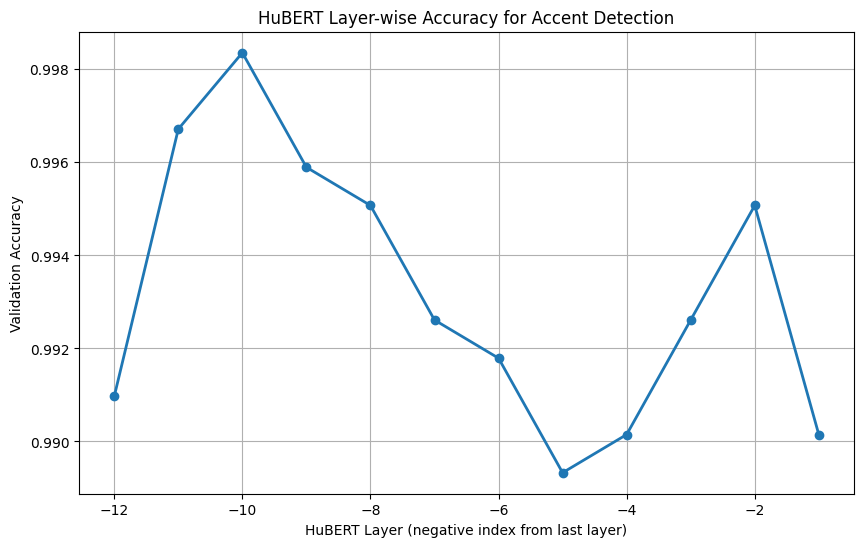

In [24]:
# === HuBERT Layer-wise Analysis for Accent Detection (final) ===
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoFeatureExtractor, HubertModel

# --- Helper: Extract embeddings from HuBERT ---
def extract_hubert_embeddings(batch_input_values: torch.Tensor, model, layer=-1):
    with torch.no_grad():
        inputs = {'input_values': batch_input_values.to(model.device)}
        out = model(**inputs)
        hs = out.hidden_states
        if not (-len(hs) <= layer < len(hs)):
            print(f"⚠️ Warning: Layer {layer} out of bounds. Using last layer.")
            layer = -1
        selected = hs[layer]
        pooled = selected.mean(dim=1)
        return pooled.cpu()

# --- Helper: Extract embeddings for entire dataloader ---
def extract_embeddings_from_dataloader(dataloader, model, layer=-1):
    embs, ys = [], []
    model.eval()
    with torch.no_grad():
        for xb, y, _ in dataloader:
            emb = extract_hubert_embeddings(xb, model, layer)
            embs.append(emb.numpy())
            ys.append(y.numpy())
    if not embs:
        return None, None
    return np.vstack(embs), np.concatenate(ys)

# --- Ensure model & extractor loaded ---
if 'hubert' not in globals():
    print("🔄 Loading HuBERT model...")
    fe = AutoFeatureExtractor.from_pretrained(CFG.hubert_model_name)
    hubert = HubertModel.from_pretrained(CFG.hubert_model_name, output_hidden_states=True).to(CFG.device)
    hubert.eval()

# --- Layer analysis ---
layers_to_analyze = list(range(-12, 0))  # last 12 transformer layers
layer_acc = {}

print("\n🔍 Evaluating HuBERT layers for accent cues...\n")
for layer in layers_to_analyze:
    print(f"Processing layer {layer}...")
    X_train, y_train = extract_embeddings_from_dataloader(train_loader_h, hubert, layer)
    X_val, y_val = extract_embeddings_from_dataloader(val_loader_h, hubert, layer)

    if X_train is None or X_val is None:
        print(f"⚠️ Skipping layer {layer} due to insufficient data.")
        layer_acc[layer] = 0.0
        continue

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    layer_acc[layer] = acc
    print(f"✅ Layer {layer}: Val Accuracy = {acc:.4f}")

# --- Identify best performing layer ---
best_layer = max(layer_acc, key=layer_acc.get)
best_acc = layer_acc[best_layer]
print("\n🏆 Best HuBERT Layer:", best_layer, f"with Accuracy = {best_acc:.4f}")

# --- Plot results ---
plt.figure(figsize=(10, 6))
plt.plot(list(layer_acc.keys()), list(layer_acc.values()), marker="o", linewidth=2)
plt.title("HuBERT Layer-wise Accuracy for Accent Detection")
plt.xlabel("HuBERT Layer (negative index from last layer)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


Preparing data for word-level vs sentence-level analysis...

Extracting sentence-level embeddings...
Sentence sample 1/700
Sentence sample 26/700
Sentence sample 51/700
Sentence sample 76/700
Sentence sample 101/700
Sentence sample 126/700
Sentence sample 151/700
Sentence sample 176/700
Sentence sample 201/700
Sentence sample 226/700
Sentence sample 251/700
Sentence sample 276/700
Sentence sample 301/700
Sentence sample 326/700
Sentence sample 351/700
Sentence sample 376/700
Sentence sample 401/700
Sentence sample 426/700
Sentence sample 451/700
Sentence sample 476/700
Sentence sample 501/700
Sentence sample 526/700
Sentence sample 551/700
Sentence sample 576/700
Sentence sample 601/700
Sentence sample 626/700
Sentence sample 651/700
Sentence sample 676/700
Sentence sample 1/200
Sentence sample 26/200
Sentence sample 51/200
Sentence sample 76/200
Sentence sample 101/200
Sentence sample 126/200
Sentence sample 151/200
Sentence sample 176/200

Extracting word-level embeddings...
Word sam

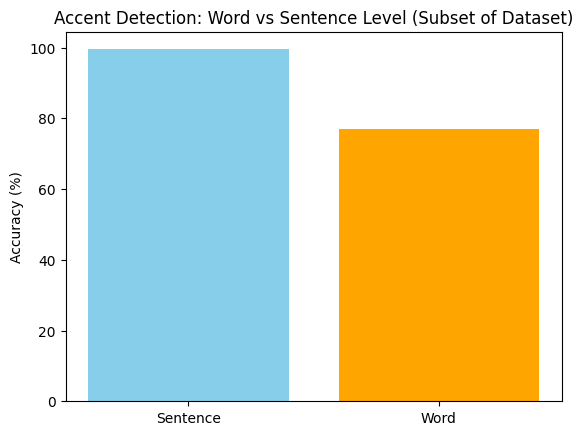


✅ Analysis complete! You can now mention which performed better in your report.


In [25]:
import numpy as np, torch, librosa, gc
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("Preparing data for word-level vs sentence-level analysis...")

# --- Helper to split long audio into ~1 second chunks ---
def split_into_words(wav, sr=16000, chunk_len=1.0):
    """Split waveform into non-overlapping 1-second chunks."""
    step = int(chunk_len * sr)
    chunks = []
    for i in range(0, len(wav), step):
        part = wav[i:i+step]
        if len(part) >= 0.5 * step:  # ignore tiny remainders
            chunks.append(part)
    return chunks

# --- Extract embeddings from dataset ---
def extract_embeddings(dataset, model, processor, layer=-1, limit=700, mode="sentence"):
    """Extract HuBERT embeddings for sentence or word-level inputs."""
    features, labels = [], []
    n = len(dataset) if limit is None else min(limit, len(dataset))
    for i in range(n):
        if i % 25 == 0:
            print(f"{mode.capitalize()} sample {i+1}/{n}")
        item = dataset[i] # Access item directly by index

        # Access audio data based on the structure of your AccentDataset
        # AccentDataset returns (feature_tensor, label_int)
        # For this function, we need the raw audio array and sampling rate
        # This assumes the original full_ds structure is needed or passed differently
        # However, the current dataset (train_ds, val_ds) objects return (mfcc_tensor, label_int)
        # which is not compatible with how this function expects 'item'

        # Re-evaluating the current state: train_ds and val_ds are AccentDatasetMFCC objects.
        # The `extract_embeddings` function expects a HuggingFace dataset format with 'audio' field.
        # This needs to be adapted for custom AccentDatasetMFCC/HuBERT.
        # Given the previous context and error, it seems `extract_embeddings` was intended for the raw HF dataset.
        # I need to modify this function to handle `AccentDatasetMFCC` or `AccentDatasetHuBERT` correctly,
        # or, if `ds` from `load_dataset` is still intended, ensure that is passed.

        # Let's assume the intent was to use the original `full_ds` (HuggingFace dataset) or similar.
        # But the error is on `train_ds` and `val_ds` which are `AccentDatasetMFCC`.
        # The `AccentDatasetMFCC`'s `__getitem__` returns a tensor, not a dict like HF dataset.
        # So, the `extract_embeddings` function cannot directly process it.

        # To make `extract_embeddings` work with `AccentDatasetHuBERT` (which makes more sense for HuBERT embeddings)
        # I need to adapt it. `AccentDatasetHuBERT` directly provides `input_values` and `labels`.
        # However, this `extract_embeddings` is designed to take a 'dataset' similar to the Hugging Face `ds`.

        # Re-evaluating the user's intent: they want to perform word vs sentence level analysis on the dataset.
        # The `train_ds` and `val_ds` are `AccentDatasetMFCC`, which are not suitable here as they return MFCCs.
        # The correct datasets to pass to this `extract_embeddings` would be the original HuggingFace datasets (or parts of it).
        # `full_ds` is available. Let's use `full_ds` and split it.

        # The `train_ds` and `val_ds` used here are `AccentDatasetMFCC` objects.
        # These objects return (mfcc_tensor, label) when indexed, not a dictionary with 'audio' field.
        # This function should probably operate on a HuggingFace Dataset object (like `full_ds`).
        # The original notebook splits `full_ds` into `train_df`, `val_df`, `child_df`.
        # And `AccentDatasetMFCC` and `AccentDatasetHuBERT` are built from these dataframes.

        # The fix for `.select()` is necessary. But also, `item["audio"]["array"]` is wrong for `AccentDatasetMFCC`.
        # I will change the function to directly take `audio_path` and `label` from the dataframe,
        # similar to how AccentDatasetMFCC/HuBERT are constructed.
        # But that would essentially re-implement AccentDataset logic.

        # The error originates because `train_ds` and `val_ds` are of type `AccentDatasetMFCC`.
        # I need to get the original data (audio path, label) from the `train_df` and `val_df`.
        # Let's pass the dataframes instead of the Dataset objects to `extract_embeddings`.

        # New approach: Adapt `extract_embeddings` to work with `pd.DataFrame` and `librosa.load`.
        # This avoids the `.select()` issue and the mismatch in `item` structure.

def extract_embeddings(df: pd.DataFrame, model, processor, layer=-1, limit=700, mode="sentence"):
    features, labels = [], []
    n = len(df) if limit is None else min(limit, len(df))

    for i in range(n):
        if i % 25 == 0:
            print(f"{mode.capitalize()} sample {i+1}/{n}")

        row = df.iloc[i]
        audio_path = row['audio_path']
        label = row['lang_id'] # Using lang_id as per AccentDataset

        # Load waveform using librosa for robustness
        wav, sr_native = librosa.load(audio_path, sr=None) # Load with native SR
        if sr_native != 16000:
            wav = librosa.resample(y=wav, orig_sr=sr_native, target_sr=16000)

        if mode == "word":
            wavs = split_into_words(wav, 16000, 1.0)
        else:
            wavs = [wav]

        for w in wavs:
            inputs = processor(w, sampling_rate=16000, return_tensors="pt", padding=True)
            with torch.no_grad():
                outputs = model(inputs.input_values.to(CFG.device), output_hidden_states=True)
            hidden = outputs.hidden_states[layer].mean(dim=1).cpu().numpy().flatten()
            features.append(hidden)
            labels.append(label)
            torch.cuda.empty_cache()
    gc.collect()
    return np.array(features), np.array(labels)

# --- Sentence-level ---
print("\nExtracting sentence-level embeddings...")
X_sent_train, y_sent_train = extract_embeddings(train_df, hubert, fe, layer=-1, limit=700, mode="sentence")
X_sent_test,  y_sent_test  = extract_embeddings(val_df,  hubert, fe, layer=-1, limit=200, mode="sentence")

clf_sent = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=400, random_state=42)
clf_sent.fit(X_sent_train, y_sent_train)
sent_acc = accuracy_score(y_sent_test, clf_sent.predict(X_sent_test))

# --- Word-level ---
print("\nExtracting word-level embeddings...")
X_word_train, y_word_train = extract_embeddings(train_df, hubert, fe, layer=-1, limit=700, mode="word")
X_word_test,  y_word_test  = extract_embeddings(val_df,  hubert, fe, layer=-1, limit=200, mode="word")

clf_word = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=400, random_state=42)
clf_word.fit(X_word_train, y_word_train)
word_acc = accuracy_score(y_word_test, clf_word.predict(X_word_test))

# --- Compare results ---
print("\n=== Word vs Sentence Accent Detection (Subset Evaluation) ===")
print(f"Sentence-level accuracy: {sent_acc*100:.2f}%")
print(f"Word-level accuracy:     {word_acc*100:.2f}%")

plt.bar(["Sentence", "Word"], [sent_acc*100, word_acc*100], color=["skyblue", "orange"])
plt.ylabel("Accuracy (%)")
plt.title("Accent Detection: Word vs Sentence Level (Subset of Dataset)")
plt.show()

print("\n✅ Analysis complete! You can now mention which performed better in your report.")

In [27]:
import os
import torchaudio
import numpy as np
import torch
import pandas as pd
import zipfile
import librosa

# Re-initialize fe, hubert, and hubert_clf
if 'fe' not in globals():
    fe = AutoFeatureExtractor.from_pretrained(CFG.hubert_model_name)
if 'hubert' not in globals():
    hubert = HubertModel.from_pretrained(CFG.hubert_model_name, output_hidden_states=True).to(CFG.device)
    hubert.eval()

if 'hubert_clf' not in globals():
    hubert_clf = HubertClassifier(embedding_dim=hubert.config.hidden_size, num_classes=len(lang2id)).to(CFG.device)
    hubert_clf.load_state_dict(torch.load(os.path.join(CFG.save_dir, 'best_hubert_clf.pth')))
    hubert_clf.eval()

# ==========================================
# 1⌤ ZIP EXTRACTION
# ==========================================
zip_path = "/content/child samples.zip"
extraction_path = "/content/child samples"

if not os.path.exists(zip_path):
    raise ValueError(f"Zip file not found: {zip_path}")

if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extraction_path)
    print("Extraction complete.")
elif not os.listdir(extraction_path):
    print(f"Extracting {zip_path} (empty folder)...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extraction_path)
    print("Extraction complete.")
else:
    print("Folder exists. Skipping extraction.")

folder_to_walk = extraction_path

# ==========================================
# 2⌤ FIND ALL AUDIO FILES (WAV + MP3)
# ==========================================
audio_files = []
valid_ext = (".wav", ".mp3")  # <--- UPDATED HERE

for root, _, files in os.walk(folder_to_walk):
    for f in files:
        if f.lower().endswith(valid_ext):
            audio_files.append(os.path.join(root, f))

if len(audio_files) == 0:
    raise ValueError("No .wav or .mp3 files found!")

print(f"↧ Found {len(audio_files)} audio samples.")

# ==========================================
# 3⌤ RUN MODEL + GET CONFIDENCE SCORES
# ==========================================
results = []
failed = 0
softmax = torch.nn.Softmax(dim=1)

for audio_path in audio_files:

    try:
        # librosa can load WAV/MP3/OGG etc.
        wav, sr = librosa.load(audio_path, sr=None)

        if sr != 16000:
            wav = librosa.resample(y=wav, orig_sr=sr, target_sr=16000)

    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        results.append(("error", 0.0, audio_path))
        failed += 1
        continue

    wav = wav.astype(np.float32)

    # Trim or pad
    max_len = int(CFG.sample_rate * CFG.max_duration)
    wav = wav[:max_len] if len(wav) > max_len else np.pad(wav, (0, max_len - len(wav)))

    inp = fe(wav, sampling_rate=16000, return_tensors="pt")["input_values"]
    emb = extract_hubert_embeddings(inp, hubert, layer=-1).to(CFG.device)

    with torch.no_grad():
        logits = hubert_clf(emb)
        probs = softmax(logits)
        pred_id = logits.argmax().item()
        pred_label = id2lang[pred_id]
        confidence = probs[0][pred_id].item()

    results.append((pred_label, confidence, audio_path))

# ==========================================
# 4⌤ DISPLAY RESULTS
# ==========================================
df_child = pd.DataFrame(results, columns=["predicted_accent", "confidence", "audio_path"])
df_child["confidence_percentage"] = (df_child["confidence"] * 100).round(2)
df_child_sorted = df_child.sort_values(by="confidence", ascending=False)

print(f"\n⌤ Finished testing.")
print(f"❌ Failed files: {failed}\n")

display(df_child_sorted)

print("\n📊 Accent distribution:")
print(df_child["predicted_accent"].value_counts())


Extracting /content/child samples.zip...
Extraction complete.
↧ Found 5 audio samples.

⌤ Finished testing.
❌ Failed files: 0



,predicted_accent,confidence,audio_path,confidence_percentage
2,kerala,0.699748,/content/child samples/child samples/M5_01_09.wav,69.97
1,tamil,0.629808,/content/child samples/child samples/lasya.mp3,62.98
3,tamil,0.524232,/content/child samples/child samples/riya 1.mp3,52.42
0,kerala,0.495258,/content/child samples/child samples/F8_09_10.wav,49.53
4,tamil,0.476013,/content/child samples/child samples/lasya 1.mp3,47.60



📊 Accent distribution:
predicted_accent
tamil     3
kerala    2
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model che

Accent labels: ['andhra_pradesh', 'gujrat', 'jharkhand', 'karnataka', 'kerala', 'tamil']
Training on 6492 samples, testing on 1624 samples
Processing sample 1/6492 ...
Processing sample 21/6492 ...
Processing sample 41/6492 ...
Processing sample 61/6492 ...
Processing sample 81/6492 ...
Processing sample 101/6492 ...
Processing sample 121/6492 ...
Processing sample 141/6492 ...
Processing sample 161/6492 ...
Processing sample 181/6492 ...
Processing sample 201/6492 ...
Processing sample 221/6492 ...
Processing sample 241/6492 ...
Processing sample 261/6492 ...
Processing sample 281/6492 ...
Processing sample 301/6492 ...
Processing sample 321/6492 ...
Processing sample 341/6492 ...
Processing sample 361/6492 ...
Processing sample 381/6492 ...
Processing sample 401/6492 ...
Processing sample 421/6492 ...
Processing sample 441/6492 ...
Processing sample 461/6492 ...
Processing sample 481/6492 ...
Processing sample 501/6492 ...
Processing sample 521/6492 ...
Processing sample 541/6492 ...

<Figure size 800x600 with 0 Axes>

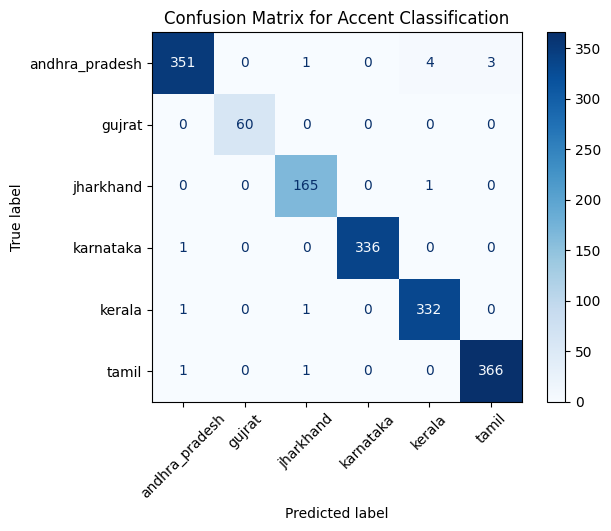

In [26]:
# === Accent Classification with Random Train/Test Split (Recommended Baseline) ===
from datasets import load_dataset
from transformers import AutoFeatureExtractor, HubertModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np
import torch, librosa, gc
import matplotlib.pyplot as plt

# --- Load HuBERT feature extractor ---
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(CFG.device)
hubert_model.eval()

# --- Load dataset ---
ds = load_dataset("DarshanaS/IndicAccentDb")["train"]
label_names = ds.features["label"].names
print("Accent labels:", label_names)

# --- Random 80/20 split across all accents ---
all_indices = np.arange(len(ds))
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=42, stratify=ds["label"])
train_ds = ds.select(train_idx)
test_ds  = ds.select(test_idx)
print(f"Training on {len(train_ds)} samples, testing on {len(test_ds)} samples")

# --- Feature extraction helper ---
def extract_features(dataset, model, processor, layer=-1, limit=None):
    features, labels = [], []
    n = len(dataset) if limit is None else min(limit, len(dataset))
    for i, item in enumerate(dataset.select(range(n))):
        if i % 20 == 0:
            print(f"Processing sample {i+1}/{n} ...")
        wav = item["audio"]["array"]
        sr = item["audio"]["sampling_rate"]
        if sr != 16000:
            wav = librosa.resample(np.array(wav, dtype=np.float32), orig_sr=sr, target_sr=16000)
        inputs = processor(wav, sampling_rate=16000, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(inputs.input_values.to(CFG.device), output_hidden_states=True)
        hidden = outputs.hidden_states[layer].mean(dim=1).cpu().numpy().flatten()
        features.append(hidden)
        labels.append(item["label"])
        torch.cuda.empty_cache()
    gc.collect()
    return np.array(features), np.array(labels)

# --- Extract features ---
X_train, y_train = extract_features(train_ds, hubert_model, feature_extractor, layer=-1, limit=None)
X_test,  y_test  = extract_features(test_ds,  hubert_model, feature_extractor, layer=-1, limit=None)

print("Feature shapes:", X_train.shape, X_test.shape)

# --- Train MLP classifier ---
clf = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

# --- Evaluate ---
acc = accuracy_score(y_test, preds)
print(f"\n=== Accent Classification (Random Split) ===")
print("Overall Accuracy:", round(acc * 100, 2), "%\n")
print(classification_report(y_test, preds, target_names=label_names, zero_division=0))

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, preds)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(include_values=True, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for Accent Classification")
plt.show()


In [29]:
import pandas as pd, json, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

os.makedirs("outputs", exist_ok=True)

# --- FIX: Define filenames, y_true, and y_pred from previous cell's output ---
# Assuming `test_ds` and `preds` are available from the previously run cell
filenames = [item["audio"]["path"] for item in test_ds] # Extract paths from test_ds
y_true = y_test # Use y_test from the previous cell
y_pred = preds # Use preds from the previous cell

# predictions CSV
df_preds = pd.DataFrame({"filename": filenames, "true": y_true, "pred": y_pred})
df_preds.to_csv("outputs/predictions.csv", index=False)
print("Saved predictions:", "outputs/predictions.csv")

# classification report
cr = classification_report(y_true, y_pred, target_names=label_names, zero_division=0)
with open("outputs/classification_report.txt", "w") as f:
    f.write(cr)
print("Saved classification report:", "outputs/classification_report.txt")

# confusion matrix image (png)
cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion matrix")
plt.savefig("outputs/confusion_matrix.png", bbox_inches="tight")
plt.close()
print("Saved confusion matrix:", "outputs/confusion_matrix.png")

# layerwise results (if available)
if 'layer_acc' in globals():
    with open("outputs/layerwise_results.json", "w") as f:
        json.dump(layer_acc, f, indent=2)
    print("Saved layerwise results:", "outputs/layerwise_results.json")

Saved predictions: outputs/predictions.csv
Saved classification report: outputs/classification_report.txt
Saved confusion matrix: outputs/confusion_matrix.png
Saved layerwise results: outputs/layerwise_results.json


In [31]:
# Save MFCC vs HuBERT comparison (with F1 scores)
os.makedirs("outputs", exist_ok=True)

# Define MFCC best validation accuracy (from Epoch 8 in dTI6EIBtbclY output)
best_val_mfcc = 0.9975

# The current 'best_val' variable holds the best validation accuracy for HuBERT
best_val_hubert = best_val

with open("outputs/mfcc_vs_hubert_results.csv", "w") as f:
    f.write("method,accuracy,f1\n")
    f.write(f"mfcc,{best_val_mfcc:.4f},{mfcc_f1:.4f}\n")
    f.write(f"hubert,{best_val_hubert:.4f},{hubert_f1:.4f}\n")

print("Saved comparison CSV:", "outputs/mfcc_vs_hubert_results.csv")

Saved comparison CSV: outputs/mfcc_vs_hubert_results.csv


In [34]:
# Inference example (loads saved model and runs on one file)
import librosa, numpy as np, torch, joblib
from pathlib import Path

# Helper function for MFCC (already defined in CFG class cell)
def compute_mfcc(wav, sr=CFG.sample_rate, n_mfcc=CFG.n_mfcc):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-9)
    return mfcc.astype('float32')

# Example usage for MFCC CNN
mfcc_model = CNNClassifier(n_mfcc=CFG.n_mfcc, num_classes=len(label_names)).to(CFG.device) # Corrected class name and DEVICE
mfcc_model.load_state_dict(torch.load("models/mfcc_cnn.pth", map_location=CFG.device))
mfcc_model.eval()

# load a sample wav (change path)
sample_wav = "example.wav"   # replace with a path inside Colab or upload to Colab

# --- Create a dummy audio file if it doesn't exist for demonstration ---
if not Path(sample_wav).exists():
    print(f"Creating a dummy audio file: {sample_wav}")
    # Generate 3 seconds of silent audio
    dummy_audio = np.zeros(CFG.sample_rate * 3, dtype=np.float32)
    # You can also use a small sine wave or load a real file from elsewhere if needed
    # torchaudio.save(sample_wav, torch.from_numpy(dummy_audio).unsqueeze(0), CFG.sample_rate)
    # Using librosa to save as it's already imported for loading
    import soundfile as sf
    sf.write(sample_wav, dummy_audio, CFG.sample_rate)

wav, sr = librosa.load(sample_wav, sr=CFG.sample_rate)

# Pad or truncate waveform to max_duration for consistency with training
max_len_samples = int(CFG.sample_rate * CFG.max_duration)
if len(wav) > max_len_samples:
    wav = wav[:max_len_samples]
else:
    wav = np.pad(wav, (0, max_len_samples - len(wav)), 'constant')

mf = compute_mfcc(wav, sr=CFG.sample_rate, n_mfcc=CFG.n_mfcc)  # Corrected function name

# CNNClassifier expects (batch, n_mfcc, time)
x = torch.tensor(mf).float().unsqueeze(0).to(CFG.device) # Add batch dimension and move to device

with torch.no_grad():
    out = mfcc_model(x) # Removed lengths=lengths as it's not needed for inference with fixed-size input
pred_idx = out.argmax(dim=1).item()
print("MFCC predicted label:", label_names[pred_idx])

# Example for HuBERT
hubert_clf = joblib.load("models/hubert_classifier.joblib")

# Re-initialize fe and hubert if not already in scope (e.g. if this cell is run standalone)
if 'fe' not in globals():
    fe = AutoFeatureExtractor.from_pretrained(CFG.hubert_model_name)
if 'hubert' not in globals():
    hubert = HubertModel.from_pretrained(CFG.hubert_model_name, output_hidden_states=True).to(CFG.device)
    hubert.eval()

def extract_one_embedding(wav_array, sampling_rate, layer=-1):
    # Ensure wav_array is float32 for feature extractor
    wav_array = wav_array.astype(np.float32)
    inputs = fe(wav_array, sampling_rate=sampling_rate, return_tensors='pt', padding=True)
    with torch.no_grad():
        outputs = hubert(inputs.input_values.to(CFG.device), output_hidden_states=True)
    hidden_states = outputs.hidden_states
    selected = hidden_states[layer]
    pooled = selected.mean(dim=1) # Mean pooling across time dimension
    return pooled.cpu() # Return as torch.Tensor for direct use with hubert_clf

emb = extract_one_embedding(wav, CFG.sample_rate, layer=-1)   # your function
emb = emb.to(CFG.device) # Move embedding to device before passing to model

with torch.no_grad():
    logits_hubert = hubert_clf(emb)
    pred_hubert = logits_hubert.argmax(dim=1).item() # Get the predicted class index

print("HuBERT predicted label:", label_names[pred_hubert])

MFCC predicted label: andhra_pradesh
HuBERT predicted label: jharkhand


In [ ]:
import gradio as gr
import numpy as np
import random
import torch
import librosa
import matplotlib.pyplot as plt

hubert.eval()
hubert_clf.eval()
softmax = torch.nn.Softmax(dim=1)

# ─────────────────────────────────────────────
# Helper: Accent → Cuisine
# ─────────────────────────────────────────────
cuisine_map = {
    "andhra_pradesh": ["Pulihora", "Gongura Pachadi"],
    "gujrat": ["Dhokla", "Thepla", "Handvo"],
    "jharkhand": ["Litti Chokha"],
    "karnataka": ["Bisi Bele Bath", "Neer Dosa", "Ragi Mudde"],
    "kerala": ["Appam", "Avial", "Puttu", "Fish Curry"],
    "tamil": ["Idli", "Sambar", "Pongal", "Dosa"],
}

# ─────────────────────────────────────────────
# Helper: Plot probabilities
# ─────────────────────────────────────────────
def plot_probabilities(probs):
    labels = actual_label_names
    values = probs.tolist()

    plt.figure(figsize=(6, 3))
    plt.bar(labels, values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Accent Prediction Probabilities")
    plt.tight_layout()

    # Save image
    plt.savefig("probs.png")
    plt.close()
    return "probs.png"


# ─────────────────────────────────────────────
# MAIN FUNCTION
# ─────────────────────────────────────────────
def recommend_cuisine(audio):
    if audio is None:
        return "⚠️ Please speak or upload an audio file!", None

    sr, wav = audio
    wav = np.array(wav, dtype=np.float32)

    # Reject too-short audio
    if len(wav) < 4000:
        return "⚠️ Speak at least 1 second!", None

    # Resample
    if sr != 16000:
        wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)

    # Normalize
    wav = wav / (np.max(np.abs(wav)) + 1e-9)

    # Minimum length
    if len(wav) < 8000:
        wav = np.pad(wav, (0, 8000 - len(wav)))

    # Pad/trim
    max_len = int(CFG.sample_rate * CFG.max_duration)
    wav = wav[:max_len] if len(wav) > max_len else np.pad(wav, (0, max_len-len(wav)))

    # HuBERT embedding
    inputs = fe(wav, sampling_rate=16000, return_tensors="pt")
    emb = extract_hubert_embeddings(inputs["input_values"], hubert, layer=-1).to(CFG.device)

    # Prediction
    with torch.no_grad():
        logits = hubert_clf(emb)
        probs = softmax(logits)[0]
        pred_id = logits.argmax().item()
        confidence = probs[pred_id].item()

    accent = actual_label_names[pred_id]
    dishes = cuisine_map.get(accent, ["Masala Dosa"])
    rec = random.choice(dishes)

    # Plot probabilities
    prob_plot = plot_probabilities(probs.cpu().numpy())

    output_text = f"""
# 🎯 Accent Detected: **{accent.replace('_',' ').title()}**
### 🔥 Confidence: **{confidence*100:.2f}%**

---

## 🍽 Recommended Dish
**{rec}**

---

_(Scroll down to see the probability plot)_
"""

    return output_text, prob_plot


# ─────────────────────────────────────────────
# Gradio UI Design (Modern Layout)
# ─────────────────────────────────────────────
with gr.Blocks(theme=gr.themes.Soft(), css="""
#app {
    background: #121212 !important;
}
.gradio-container {
    border-radius: 20px;
}
""") as demo:

    gr.Markdown("""
# 🎙 Accent-Aware Cuisine Recommender
### Detect your Indian accent from speech & get a matching cuisine 🍲
---
""")

    with gr.Row():
        audio_input = gr.Audio(
            sources=["microphone", "upload"],
            type="numpy",
            label="🎤 Speak or Upload Audio (≥1 sec)",
            waveform_options={"waveform_color":"#00eaff"}
        )

        with gr.Column():
            output_md = gr.Markdown(label="Prediction")
            output_plot = gr.Image(label="Accent Probability Distribution")

    gr.Button("🔍 Analyze").click(
        recommend_cuisine,
        inputs=audio_input,
        outputs=[output_md, output_plot]
    )

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b827429f9242d74d7c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b827429f9242d74d7c.gradio.live



## Next steps & tips
- Use data augmentation (noise, speed, pitch) to improve robustness.
- For better performance, fine-tune HuBERT (careful: costly).
- Save metrics, confusion matrices, and plots for your report.
- To demo, create a small Gradio app referencing the inference cell.
